Importing the required libraries and constants

In [2]:
import os, pathlib, json, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score

SEED = 42
IMG_SIZE = (224, 224)
BATCH = 32

ROOT_DIR = pathlib.Path("data/")
TRAIN_DIR = ROOT_DIR / "training"
VAL_DIR   = ROOT_DIR / "validation"
MODEL_DIR = "models"

This file is for training the various image classification models

In [3]:
import tensorflow as tf
from tensorflow import keras

# Build datasets WITHOUT validation_split
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False   # keep order stable for metrics/plots
)

# Class names (e.g., ['01-minor','02-moderate','03-severe'])
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# (Optional) pretty labels for display, stripping the numeric prefixes
pretty_names = [c.split('-', 1)[-1] if '-' in c else c for c in class_names]

AUTOTUNE = tf.data.AUTOTUNE
def configure(ds, training=False):
    ds = ds.cache()
    if training:
        ds = ds.shuffle(1024, seed=SEED)
    return ds.prefetch(AUTOTUNE)

train_ds = configure(train_ds, training=True)
val_ds   = configure(val_ds)

Found 1783 files belonging to 4 classes.
Found 388 files belonging to 4 classes.
Classes: ['00-none', '01-minor', '02-moderate', '03-severe']


Setting up F1 function for performance evaluation

In [4]:
import numpy as np
from sklearn.metrics import f1_score

class MacroF1Callback(keras.callbacks.Callback):
    def __init__(self, val_ds, num_classes):
        super().__init__()
        self.val_ds = val_ds
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []
        for xb, yb in self.val_ds:
            probs = self.model.predict(xb, verbose=0)
            y_pred.extend(np.argmax(probs, axis=1))
            # yb may be ints or one-hot depending on your pipeline:
            if yb.ndim == 2:  # one-hot
                y_true.extend(np.argmax(yb.numpy(), axis=1))
            else:             # integer labels
                y_true.extend(yb.numpy())
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        macro_f1 = f1_score(y_true, y_pred, average="macro")
        logs = logs or {}
        logs["val_macro_f1"] = macro_f1
        print(f"\nval_macro_f1: {macro_f1:.4f}")

In [5]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augment")

preprocess = keras.applications.efficientnet_v2.preprocess_input

base = keras.applications.EfficientNetV2B0(
    include_top=False, weights="imagenet", input_shape=(*IMG_SIZE, 3)
)
base.trainable = False

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,924,436 (22.60 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

# 5. Training with Checkpoint

Early stopping with checkpoint. we start with frozen and then unlock the model. GPU enabled runtime will run much faster. If you plot the curves what can it tell you on the epochs?

In [6]:
EPOCHS_FROZEN = 8
EPOCHS_FINE   = 12

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")]
)

# If your datasets are integer labels, map to one-hot for this loss:
train_oh = train_ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)))
val_oh   = val_ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)))

f1_cb = MacroF1Callback(val_ds, NUM_CLASSES)

#Model filename
filename = MODEL_DIR + "\\best_frozen.keras"

ckpt1 = keras.callbacks.ModelCheckpoint(
    filename, monitor="val_macro_f1", mode="max",
    save_best_only=True, verbose=1
)
early = keras.callbacks.EarlyStopping(monitor="val_macro_f1", mode="max",
                                      patience=5, restore_best_weights=True)
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                           factor=0.5, patience=2, verbose=1)

hist1 = model.fit(
    train_oh, validation_data=val_oh,
    epochs=EPOCHS_FROZEN, callbacks=[f1_cb, ckpt1, early, reduce], verbose=2
)

Epoch 1/8

val_macro_f1: 0.5131

Epoch 1: val_macro_f1 improved from None to 0.51310, saving model to models\best_frozen.keras
56/56 - 65s - 1s/step - acc: 0.3943 - loss: 1.3058 - val_acc: 0.5851 - val_loss: 1.1081 - val_macro_f1: 0.5131 - learning_rate: 3.0000e-04
Epoch 2/8

val_macro_f1: 0.5851

Epoch 2: val_macro_f1 improved from 0.51310 to 0.58513, saving model to models\best_frozen.keras
56/56 - 44s - 781ms/step - acc: 0.5283 - loss: 1.1422 - val_acc: 0.6366 - val_loss: 1.0007 - val_macro_f1: 0.5851 - learning_rate: 3.0000e-04
Epoch 3/8

val_macro_f1: 0.6143

Epoch 3: val_macro_f1 improved from 0.58513 to 0.61425, saving model to models\best_frozen.keras
56/56 - 44s - 786ms/step - acc: 0.5665 - loss: 1.0504 - val_acc: 0.6778 - val_loss: 0.9056 - val_macro_f1: 0.6143 - learning_rate: 3.0000e-04
Epoch 4/8

val_macro_f1: 0.6452

Epoch 4: val_macro_f1 improved from 0.61425 to 0.64523, saving model to models\best_frozen.keras
56/56 - 44s - 780ms/step - acc: 0.5984 - loss: 1.0037 - val_

6. Unfreeze (Fine Tuning)

In [7]:
# Unfreeze top layers except BatchNorm
for layer in base.layers[-60:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")]
)

filename = MODEL_DIR + "\\best_finetuned.keras"
f1_cb2 = MacroF1Callback(val_ds, NUM_CLASSES)
ckpt2 = keras.callbacks.ModelCheckpoint(
    filename, monitor="val_macro_f1", mode="max",
    save_best_only=True, verbose=1
)

hist2 = model.fit(
    train_oh, validation_data=val_oh,
    epochs=EPOCHS_FINE, callbacks=[f1_cb2, ckpt2, early, reduce], verbose=2
)

Epoch 1/12

val_macro_f1: 0.7147

Epoch 1: val_macro_f1 improved from None to 0.71472, saving model to models\best_finetuned.keras
56/56 - 68s - 1s/step - acc: 0.6618 - loss: 0.8806 - val_acc: 0.7474 - val_loss: 0.7416 - val_macro_f1: 0.7147 - learning_rate: 1.0000e-05
Epoch 2/12

val_macro_f1: 0.7153

Epoch 2: val_macro_f1 improved from 0.71472 to 0.71534, saving model to models\best_finetuned.keras
56/56 - 52s - 927ms/step - acc: 0.6624 - loss: 0.8751 - val_acc: 0.7474 - val_loss: 0.7212 - val_macro_f1: 0.7153 - learning_rate: 1.0000e-05
Epoch 3/12

val_macro_f1: 0.7226

Epoch 3: val_macro_f1 improved from 0.71534 to 0.72255, saving model to models\best_finetuned.keras
56/56 - 58s - 1s/step - acc: 0.6826 - loss: 0.8472 - val_acc: 0.7552 - val_loss: 0.7077 - val_macro_f1: 0.7226 - learning_rate: 1.0000e-05
Epoch 4/12

val_macro_f1: 0.7317

Epoch 4: val_macro_f1 improved from 0.72255 to 0.73172, saving model to models\best_finetuned.keras
56/56 - 55s - 988ms/step - acc: 0.6966 - loss: 

7. Performance Evaluation
there are also other things to show. can you think of any?

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
MODEL_FILE = MODEL_DIR + "\\best_frozen.keras"

best = keras.models.load_model(MODEL_FILE, compile=False)
best.compile(optimizer=keras.optimizers.Adam(1e-5),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=["accuracy"])

y_true, y_pred = [], []
for xb, yb in val_ds:
    probs = best.predict(xb, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    if yb.ndim == 2: y_true.extend(np.argmax(yb.numpy(), axis=1))
    else:            y_true.extend(yb.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("Macro-F1:", f1_score(y_true, y_pred, average="macro"))


Confusion matrix:
 [[129   2   9   0]
 [  5  64  12   1]
 [ 13  14  36  12]
 [  2   1  31  57]]

Classification report:
              precision    recall  f1-score   support

     00-none       0.87      0.92      0.89       140
    01-minor       0.79      0.78      0.79        82
 02-moderate       0.41      0.48      0.44        75
   03-severe       0.81      0.63      0.71        91

    accuracy                           0.74       388
   macro avg       0.72      0.70      0.71       388
weighted avg       0.75      0.74      0.74       388

Macro-F1: 0.7069504908015016


Found 7251 files belonging to 5 classes.
Using 725 files for validation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


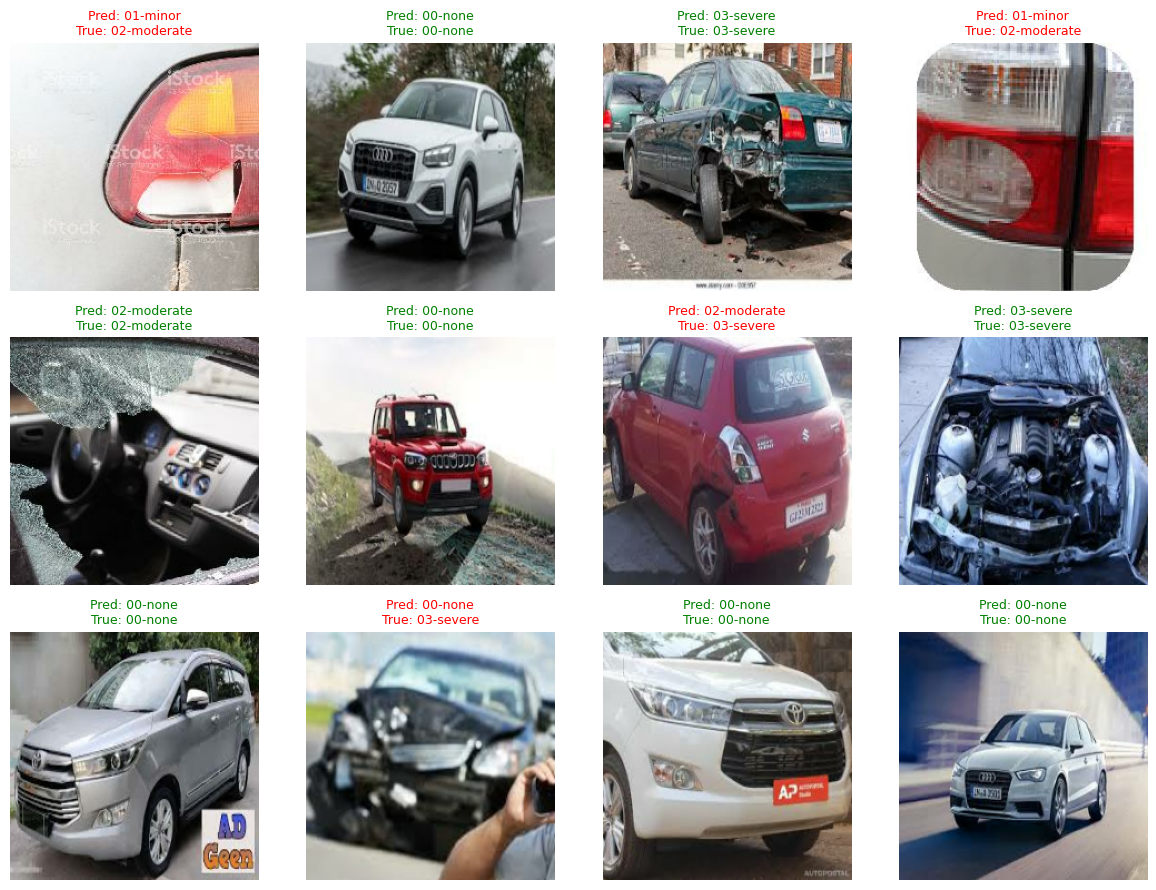

In [10]:
import matplotlib.pyplot as plt
import random
MODEL_FILE = MODEL_DIR + "\\best_finetuned.keras"

# Create a dataset with raw images and labels (no one-hot)
val_raw = tf.keras.utils.image_dataset_from_directory(
    ROOT_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=0.1,
    subset="validation",
    shuffle=True
)

# Get a small batch
images, labels = next(iter(val_raw))
pred_probs = best.predict(images)
pred_ids = np.argmax(pred_probs, axis=1)
true_ids = labels.numpy()

# Plot 12 random samples
plt.figure(figsize=(12, 9))
for i, idx in enumerate(random.sample(range(len(images)), 12)):
    ax = plt.subplot(3, 4, i + 1)
    img = images[idx].numpy().astype("uint8")
    true_label = class_names[true_ids[idx]]
    pred_label = class_names[pred_ids[idx]]
    color = "green" if pred_label == true_label else "red"
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()